# Прогнозирование почасового потребления электроэнергии с исследованием влияния различных искажений данных на качество ML-моделей

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as std
sns.set()

import os
import datetime

import IPython
import IPython.display
from pylab import rcParams
import matplotlib as mpl
from matplotlib import rc
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters

In [ ]:
import statsmodels as smd

In [ ]:
#opensource dataset. Danish Meteoroligical Institut
data = pd.read_csv(r'/content/weather-energy-data-update.csv')

In [ ]:
data.head()

,Datetime,kWh,hour,day_of_month,day_of_week,month,is_weekend,pressure_at_sea,precip_dur_past10min,wind_dir,wind_speed,temp_dew,pressure,visib_mean_last10min,temp_dry,humidity,cloud_cover,visibility
0,11/1/2018 0:00,0.247,0.0,1.0,3.0,11.0,0,1017.966667,0.0,115.166667,2.616667,5.900000,1011.083333,8150.00000,6.150000,98.333333,5.000000,7666.666667
1,11/1/2018 1:00,0.131,1.0,1.0,3.0,11.0,0,1017.750000,0.0,119.500000,2.733333,6.250000,1010.883333,13666.66667,6.833333,96.166667,44.166667,13333.333330
2,11/1/2018 2:00,0.132,2.0,1.0,3.0,11.0,0,1017.500000,0.0,121.500000,3.016667,5.950000,1010.600000,22416.66667,7.383333,90.833333,77.500000,22000.000000
3,11/1/2018 3:00,0.076,3.0,1.0,3.0,11.0,0,1017.366667,0.0,124.166667,3.700000,5.616667,1010.533333,31483.33333,7.766667,86.166667,95.000000,29666.666670
4,11/1/2018 4:00,0.061,4.0,1.0,3.0,11.0,0,1016.916667,0.0,117.666667,3.333333,5.516667,1010.100000,36266.66667,7.866667,85.000000,95.000000,34166.666670


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26328 entries, 0 to 26327
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Datetime              26328 non-null  object 
 1   kWh                   26328 non-null  float64
 2   hour                  26328 non-null  float64
 3   day_of_month          26328 non-null  float64
 4   day_of_week           26328 non-null  float64
 5   month                 26328 non-null  float64
 6   is_weekend            26328 non-null  int64  
 7   pressure_at_sea       26323 non-null  float64
 8   precip_dur_past10min  26323 non-null  float64
 9   wind_dir              26323 non-null  float64
 10  wind_speed            26323 non-null  float64
 11  temp_dew              26323 non-null  float64
 12  pressure              26323 non-null  float64
 13  visib_mean_last10min  26323 non-null  float64
 14  temp_dry              26323 non-null  float64
 15  humidity           

In [ ]:
data['Datetime'] = pd.to_datetime(data['Datetime'])
data['Date']=pd.to_datetime(data['Datetime'].dt.date)
data['Year']=data['Datetime'].dt.year
data['month_year'] = data['Datetime'].dt.to_period('M')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26328 entries, 0 to 26327
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Datetime              26328 non-null  datetime64[ns]
 1   kWh                   26328 non-null  float64       
 2   hour                  26328 non-null  float64       
 3   day_of_month          26328 non-null  float64       
 4   day_of_week           26328 non-null  float64       
 5   month                 26328 non-null  float64       
 6   is_weekend            26328 non-null  int64         
 7   pressure_at_sea       26323 non-null  float64       
 8   precip_dur_past10min  26323 non-null  float64       
 9   wind_dir              26323 non-null  float64       
 10  wind_speed            26323 non-null  float64       
 11  temp_dew              26323 non-null  float64       
 12  pressure              26323 non-null  float64       
 13  visib_mean_last1

# Trend

To find the daily electricity consumptions let us data to daily format taking sum of kWh used and mean of metereology features

In [ ]:
data_by_day=data.groupby('Date').agg({'kWh':'sum','pressure_at_sea':'mean', 'precip_dur_past10min':'mean', 'wind_dir':'mean', 
                                      'temp_dew':'mean', 'pressure':'mean', 'visib_mean_last10min':'mean', 'temp_dry':'mean',
                                     'humidity':'mean', 'cloud_cover':'mean', 'visibility':'mean'})

In [ ]:
data_by_day.head()

,kWh,pressure_at_sea,precip_dur_past10min,wind_dir,temp_dew,pressure,visib_mean_last10min,temp_dry,humidity,cloud_cover,visibility
Date,,,,,,,,,,,
2018-11-01,4.775,1013.800000,0.000000,108.416667,7.006250,1007.004167,21387.500001,8.580556,89.986111,50.694444,20273.611111
2018-11-02,2.835,1014.878472,0.013889,218.444444,7.073611,1008.075694,20074.305556,8.381944,91.659722,70.659722,18984.722222
2018-11-03,1.559,1026.250695,0.000000,208.854167,4.184028,1019.306250,26798.611111,5.768056,90.034722,2.118056,25729.166668
2018-11-04,1.536,1021.014583,0.000000,146.381944,5.393056,1014.110417,9704.166667,6.134028,95.131944,60.902778,9334.722222
2018-11-05,2.833,1014.650000,0.000000,101.263889,8.660417,1007.852778,3318.472222,8.827778,98.979167,100.000000,3296.527778


In [ ]:
# !pip install git+https://github.com/statsmodels/statsmodels

# !pip uninstall patsy

# !pip install patsy

In [ ]:
from statsmodels.compat.pandas import Appender, is_int_index, to_numpy

from abc import ABC, abstractmethod
import datetime as dt
from typing import Hashable, List, Optional, Sequence, Set, Tuple, Type, Union

import numpy as np
import pandas as pd
from scipy.linalg import qr

from statsmodels.iolib.summary import d_or_f
from statsmodels.tools.validation import (
    bool_like,
    float_like,
    required_int_like,
    string_like,
)
from statsmodels.tsa.tsatools import freq_to_period

DateLike = Union[dt.datetime, pd.Timestamp, np.datetime64]
IntLike = Union[int, np.integer]


START_BEFORE_INDEX_ERR = """\
start is less than the first observation in the index. Values can only be \
created for observations after the start of the index.
"""


class DeterministicTerm(ABC):
    """Abstract Base Class for all Deterministic Terms"""

    # Set _is_dummy if the term is a dummy variable process
    _is_dummy = False

    @property
    def is_dummy(self) -> bool:
        """Flag indicating whether the values produced are dummy variables"""
        return self._is_dummy

    @abstractmethod
    def in_sample(self, index: Sequence[Hashable]) -> pd.DataFrame:
        """
        Produce deterministic trends for in-sample fitting.

        Parameters
        ----------
        index : index_like
            An index-like object. If not an index, it is converted to an
            index.

        Returns
        -------
        DataFrame
            A DataFrame containing the deterministic terms.
        """


    @abstractmethod
    def out_of_sample(
        self,
        steps: int,
        index: Sequence[Hashable],
        forecast_index: Optional[Sequence[Hashable]] = None,
    ) -> pd.DataFrame:
        """
        Produce deterministic trends for out-of-sample forecasts

        Parameters
        ----------
        steps : int
            The number of steps to forecast
        index : index_like
            An index-like object. If not an index, it is converted to an
            index.
        forecast_index : index_like
            An Index or index-like object to use for the forecasts. If
            provided must have steps elements.

        Returns
        -------
        DataFrame
            A DataFrame containing the deterministic terms.
        """


    @abstractmethod
    def __str__(self) -> str:
        """A meaningful string representation of the term"""

    def __hash__(self) -> int:
        name: Tuple[Hashable, ...] = (type(self).__name__,)
        return hash(name + self._eq_attr)

    @property
    @abstractmethod
    def _eq_attr(self) -> Tuple[Hashable, ...]:
        """tuple of attributes that are used for equality comparison"""

    @staticmethod
    def _index_like(index: Sequence[Hashable]) -> pd.Index:
        if isinstance(index, pd.Index):
            return index
        try:
            return pd.Index(index)
        except Exception:
            raise TypeError("index must be a pandas Index or index-like")

    @staticmethod
    def _extend_index(
        index: pd.Index,
        steps: int,
        forecast_index: Optional[Sequence[Hashable]] = None,
    ) -> pd.Index:
        """Extend the forecast index"""
        if forecast_index is not None:
            forecast_index = DeterministicTerm._index_like(forecast_index)
            assert isinstance(forecast_index, pd.Index)
            if forecast_index.shape[0] != steps:
                raise ValueError(
                    "The number of values in forecast_index "
                    f"({forecast_index.shape[0]}) must match steps ({steps})."
                )
            return forecast_index
        if isinstance(index, pd.PeriodIndex):
            return pd.period_range(
                index[-1] + 1, periods=steps, freq=index.freq
            )
        elif isinstance(index, pd.DatetimeIndex) and index.freq is not None:
            next_obs = pd.date_range(index[-1], freq=index.freq, periods=2)[1]
            return pd.date_range(next_obs, freq=index.freq, periods=steps)
        elif isinstance(index, pd.RangeIndex):
            assert isinstance(index, pd.RangeIndex)
            try:
                step = index.step
                start = index.stop
            except AttributeError:
                # TODO: Remove after pandas min ver is 1.0.0+
                step = index[-1] - index[-2] if len(index) > 1 else 1
                start = index[-1] + step
            stop = start + step * steps
            return pd.RangeIndex(start, stop, step=step)
        elif is_int_index(index) and np.all(np.diff(index) == 1):
            idx_arr = np.arange(index[-1] + 1, index[-1] + steps + 1)
            return pd.Index(idx_arr)
        # default range index
        import warnings

        warnings.warn(
            "Only PeriodIndexes, DatetimeIndexes with a frequency set, "
            "RangesIndexes, and Index with a unit increment support "
            "extending. The index is set will contain the position relative "
            "to the data length.",
            UserWarning,
            stacklevel=2,
        )
        nobs = index.shape[0]
        return pd.RangeIndex(nobs + 1, nobs + steps + 1)

    def __repr__(self) -> str:
        return self.__str__() + f" at 0x{id(self):0x}"

    def __eq__(self, other: object) -> bool:
        if isinstance(other, type(self)):
            own_attr = self._eq_attr
            oth_attr = other._eq_attr
            if len(own_attr) != len(oth_attr):
                return False
            return all([a == b for a, b in zip(own_attr, oth_attr)])
        else:
            return False



class TimeTrendDeterministicTerm(DeterministicTerm, ABC):
    """Abstract Base Class for all Time Trend Deterministic Terms"""

    def __init__(self, constant: bool = True, order: int = 0) -> None:
        self._constant = bool_like(constant, "constant")
        self._order = required_int_like(order, "order")

    @property
    def constant(self) -> bool:
        """Flag indicating that a constant is included"""
        return self._constant

    @property
    def order(self) -> int:
        """Order of the time trend"""
        return self._order

    @property
    def _columns(self) -> List[str]:
        columns = []
        trend_names = {1: "trend", 2: "trend_squared", 3: "trend_cubed"}
        if self._constant:
            columns.append("const")
        for power in range(1, self._order + 1):
            if power in trend_names:
                columns.append(trend_names[power])
            else:
                columns.append(f"trend**{power}")
        return columns

    def _get_terms(self, locs: np.ndarray) -> np.ndarray:
        nterms = int(self._constant) + self._order
        terms = np.tile(locs, (1, nterms))
        power = np.zeros((1, nterms), dtype=int)
        power[0, int(self._constant) :] = np.arange(1, self._order + 1)
        terms **= power
        return terms

    def __str__(self) -> str:
        terms = []
        if self._constant:
            terms.append("Constant")
        if self._order:
            terms.append(f"Powers 1 to {self._order + 1}")
        if not terms:
            terms = ["Empty"]
        terms_str = ",".join(terms)
        return f"TimeTrend({terms_str})"



class TimeTrend(TimeTrendDeterministicTerm):
    """
    Constant and time trend determinstic terms

    Parameters
    ----------
    constant : bool
        Flag indicating whether a constant should be included.
    order : int
        A non-negative int containing the powers to include (1, 2, ..., order).

    See Also
    --------
    DeterministicProcess
    Seasonality
    Fourier
    CalendarTimeTrend

    Examples
    --------
    >>> from statsmodels.datasets import sunspots
    >>> from statsmodels.tsa.deterministic import TimeTrend
    >>> data = sunspots.load_pandas().data
    >>> trend_gen = TimeTrend(True, 3)
    >>> trend_gen.in_sample(data.index)
    """

    def __init__(self, constant: bool = True, order: int = 0) -> None:
        super().__init__(constant, order)

    @classmethod
    def from_string(cls, trend: str) -> "TimeTrend":
        """
        Create a TimeTrend from a string description.

        Provided for compatibility with common string names.

        Parameters
        ----------
        trend : {"n", "c", "t", "ct", "ctt"}
            The string representation of the time trend. The terms are:

            * "n": No trend terms
            * "c": A constant only
            * "t": Linear time trend only
            * "ct": A constant and a time trend
            * "ctt": A constant, a time trend and a quadratic time trend

        Returns
        -------
        TimeTrend
            The TimeTrend instance.
        """
        constant = trend.startswith("c")
        order = 0
        if "tt" in trend:
            order = 2
        elif "t" in trend:
            order = 1
        return cls(constant=constant, order=order)


    @Appender(DeterministicTerm.in_sample.__doc__)
    def in_sample(
        self, index: Union[Sequence[Hashable], pd.Index]
    ) -> pd.DataFrame:
        index = self._index_like(index)
        nobs = index.shape[0]
        locs = np.arange(1, nobs + 1, dtype=np.double)[:, None]
        terms = self._get_terms(locs)
        return pd.DataFrame(terms, columns=self._columns, index=index)


    @Appender(DeterministicTerm.out_of_sample.__doc__)
    def out_of_sample(
        self,
        steps: int,
        index: Union[Sequence[Hashable], pd.Index],
        forecast_index: Optional[Sequence[Hashable]] = None,
    ) -> pd.DataFrame:
        index = self._index_like(index)
        nobs = index.shape[0]
        fcast_index = self._extend_index(index, steps, forecast_index)
        locs = np.arange(nobs + 1, nobs + steps + 1, dtype=np.double)[:, None]
        terms = self._get_terms(locs)
        return pd.DataFrame(terms, columns=self._columns, index=fcast_index)


    @property
    def _eq_attr(self) -> Tuple[Hashable, ...]:
        return self._constant, self._order



class Seasonality(DeterministicTerm):
    """
    Seasonal dummy deterministic terms

    Parameters
    ----------
    period : int
        The length of a full cycle. Must be >= 2.
    initial_period : int
        The seasonal index of the first observation. 1-indexed so must
        be in {1, 2, ..., period}.

    See Also
    --------
    DeterministicProcess
    TimeTrend
    Fourier
    CalendarSeasonality

    Examples
    --------
    Solar data has an 11-year cycle

    >>> from statsmodels.datasets import sunspots
    >>> from statsmodels.tsa.deterministic import Seasonality
    >>> data = sunspots.load_pandas().data
    >>> seas_gen = Seasonality(11)
    >>> seas_gen.in_sample(data.index)

    To start at a season other than 1

    >>> seas_gen = Seasonality(11, initial_period=4)
    >>> seas_gen.in_sample(data.index)
    """

    _is_dummy = True

    def __init__(self, period: int, initial_period: int = 1) -> None:
        self._period = required_int_like(period, "period")
        self._initial_period = required_int_like(
            initial_period, "initial_period"
        )
        if period < 2:
            raise ValueError("period must be >= 2")
        if not 1 <= self._initial_period <= period:
            raise ValueError("initial_period must be in {1, 2, ..., period}")

    @property
    def period(self) -> int:
        """The period of the seasonality"""
        return self._period

    @property
    def initial_period(self) -> int:
        """The seasonal index of the first observation"""
        return self._initial_period

    @classmethod
    def from_index(
        cls, index: Union[Sequence[Hashable], pd.DatetimeIndex, pd.PeriodIndex]
    ) -> "Seasonality":
        """
        Construct a seasonality directly from an index using its frequency.

        Parameters
        ----------
        index : {DatetimeIndex, PeriodIndex}
            An index with its frequency (`freq`) set.

        Returns
        -------
        Seasonality
            The initialized Seasonality instance.
        """
        index = cls._index_like(index)
        if isinstance(index, pd.PeriodIndex):
            freq = index.freq
        elif isinstance(index, pd.DatetimeIndex):
            freq = index.freq if index.freq else index.inferred_freq
        else:
            raise TypeError("index must be a DatetimeIndex or PeriodIndex")
        if freq is None:
            raise ValueError("index must have a freq or inferred_freq set")
        period = freq_to_period(freq)
        return cls(period=period)


    @property
    def _eq_attr(self) -> Tuple[Hashable, ...]:
        return self._period, self._initial_period

    def __str__(self) -> str:
        return f"Seasonality(period={self._period})"

    @property
    def _columns(self) -> List[str]:
        period = self._period
        columns = []
        for i in range(1, period + 1):
            columns.append(f"s({i},{period})")
        return columns

    @Appender(DeterministicTerm.in_sample.__doc__)
    def in_sample(
        self, index: Union[Sequence[Hashable], pd.Index]
    ) -> pd.DataFrame:
        index = self._index_like(index)
        nobs = index.shape[0]
        period = self._period
        term = np.zeros((nobs, period))
        offset = self._initial_period - 1
        for i in range(period):
            col = (i + offset) % period
            term[i::period, col] = 1
        return pd.DataFrame(term, columns=self._columns, index=index)


    @Appender(DeterministicTerm.out_of_sample.__doc__)
    def out_of_sample(
        self,
        steps: int,
        index: Union[Sequence[Hashable], pd.Index],
        forecast_index: Optional[Sequence[Hashable]] = None,
    ) -> pd.DataFrame:
        index = self._index_like(index)
        fcast_index = self._extend_index(index, steps, forecast_index)
        nobs = index.shape[0]
        period = self._period
        term = np.zeros((steps, period))
        offset = self._initial_period - 1
        for i in range(period):
            col_loc = (nobs + offset + i) % period
            term[i::period, col_loc] = 1
        return pd.DataFrame(term, columns=self._columns, index=fcast_index)



class FourierDeterministicTerm(DeterministicTerm, ABC):
    """Abstract Base Class for all Fourier Deterministic Terms"""

    def __init__(self, order: int) -> None:
        self._order = required_int_like(order, "terms")

    @property
    def order(self) -> int:
        """The order of the Fourier terms included"""
        return self._order

    def _get_terms(self, locs: np.ndarray) -> np.ndarray:
        locs = 2 * np.pi * locs.astype(np.double)
        terms = np.empty((locs.shape[0], 2 * self._order))
        for i in range(self._order):
            for j, func in enumerate((np.sin, np.cos)):
                terms[:, 2 * i + j] = func((i + 1) * locs)
        return terms



class Fourier(FourierDeterministicTerm):
    r"""
    Fourier series deterministic terms

    Parameters
    ----------
    period : int
        The length of a full cycle. Must be >= 2.
    order : int
        The number of Fourier components to include. Must be <= 2*period.

    See Also
    --------
    DeterministicProcess
    TimeTrend
    Seasonality
    CalendarFourier

    Notes
    -----
    Both a sine and a cosine term are included for each i=1, ..., order

    .. math::

       f_{i,s,t} & = \sin\left(2 \pi i \times \frac{t}{m} \right)  \\
       f_{i,c,t} & = \cos\left(2 \pi i \times \frac{t}{m} \right)

    where m is the length of the period.

    Examples
    --------
    Solar data has an 11-year cycle

    >>> from statsmodels.datasets import sunspots
    >>> from statsmodels.tsa.deterministic import Fourier
    >>> data = sunspots.load_pandas().data
    >>> fourier_gen = Fourier(11, order=2)
    >>> fourier_gen.in_sample(data.index)
    """
    _is_dummy = False

    def __init__(self, period: float, order: int):
        super().__init__(order)
        self._period = float_like(period, "period")
        if 2 * self._order > self._period:
            raise ValueError("2 * order must be <= period")

    @property
    def period(self) -> float:
        """The period of the Fourier terms"""
        return self._period

    @property
    def _columns(self) -> List[str]:
        period = self._period
        fmt_period = d_or_f(period).strip()
        columns = []
        for i in range(1, self._order + 1):
            for typ in ("sin", "cos"):
                columns.append(f"{typ}({i},{fmt_period})")
        return columns

    @Appender(DeterministicTerm.in_sample.__doc__)
    def in_sample(
        self, index: Union[Sequence[Hashable], pd.Index]
    ) -> pd.DataFrame:
        index = self._index_like(index)
        nobs = index.shape[0]
        terms = self._get_terms(np.arange(nobs) / self._period)
        return pd.DataFrame(terms, index=index, columns=self._columns)


    @Appender(DeterministicTerm.out_of_sample.__doc__)
    def out_of_sample(
        self,
        steps: int,
        index: Union[Sequence[Hashable], pd.Index],
        forecast_index: Optional[Sequence[Hashable]] = None,
    ) -> pd.DataFrame:
        index = self._index_like(index)
        fcast_index = self._extend_index(index, steps, forecast_index)
        nobs = index.shape[0]
        terms = self._get_terms(np.arange(nobs, nobs + steps) / self._period)
        return pd.DataFrame(terms, index=fcast_index, columns=self._columns)


    @property
    def _eq_attr(self) -> Tuple[Hashable, ...]:
        return self._period, self._order

    def __str__(self) -> str:
        return f"Fourier(period={self._period}, order={self._order})"



class CalendarDeterministicTerm(DeterministicTerm, ABC):
    """Abstract Base Class for calendar deterministic terms"""

    def __init__(self, freq: str) -> None:
        try:
            index = pd.date_range("2020-01-01", freq=freq, periods=1)
            self._freq = index.freq
        except ValueError:
            raise ValueError("freq is not understood by pandas")

    @property
    def freq(self) -> str:
        """The frequency of the deterministic terms"""
        return self._freq.freqstr

    def _compute_ratio(
        self, index: Union[pd.DatetimeIndex, pd.PeriodIndex]
    ) -> np.ndarray:
        if isinstance(index, pd.PeriodIndex):
            index = index.to_timestamp()
        delta = index - index.to_period(self._freq).to_timestamp()
        pi = index.to_period(self._freq)
        gap = (pi + 1).to_timestamp() - pi.to_timestamp()
        return to_numpy(delta) / to_numpy(gap)

    def _check_index_type(
        self,
        index: pd.Index,
        allowed: Union[Type, Tuple[Type, ...]] = (
            pd.DatetimeIndex,
            pd.PeriodIndex,
        ),
    ) -> Union[pd.DatetimeIndex, pd.PeriodIndex]:
        if isinstance(allowed, type):
            allowed = (allowed,)
        if not isinstance(index, allowed):
            if len(allowed) == 1:
                allowed_types = "a " + allowed[0].__name__
            else:
                allowed_types = ", ".join(a.__name__ for a in allowed[:-1])
                if len(allowed) > 2:
                    allowed_types += ","
                allowed_types += " and " + allowed[-1].__name__
            msg = (
                f"{type(self).__name__} terms can only be computed from "
                f"{allowed_types}"
            )
            raise TypeError(msg)
        assert isinstance(index, (pd.DatetimeIndex, pd.PeriodIndex))
        return index



class CalendarFourier(CalendarDeterministicTerm, FourierDeterministicTerm):
    r"""
    Fourier series deterministic terms based on calendar time

    Parameters
    ----------
    freq : str
        A string convertible to a pandas frequency.
    order : int
        The number of Fourier components to include. Must be <= 2*period.

    See Also
    --------
    DeterministicProcess
    CalendarTimeTrend
    CalendarSeasonality
    Fourier

    Notes
    -----
    Both a sine and a cosine term are included for each i=1, ..., order

    .. math::

       f_{i,s,t} & = \sin\left(2 \pi i \tau_t \right)  \\
       f_{i,c,t} & = \cos\left(2 \pi i \tau_t \right)

    where m is the length of the period and :math:`\tau_t` is the frequency
    normalized time.  For example, when freq is "D" then an observation with
    a timestamp of 12:00:00 would have :math:`\tau_t=0.5`.

    Examples
    --------
    Here we simulate irregularly spaced hourly data and construct the calendar
    Fourier terms for the data.

    >>> import numpy as np
    >>> import pandas as pd
    >>> base = pd.Timestamp("2020-1-1")
    >>> gen = np.random.default_rng()
    >>> gaps = np.cumsum(gen.integers(0, 1800, size=1000))
    >>> times = [base + pd.Timedelta(gap, unit="s") for gap in gaps]
    >>> index = pd.DatetimeIndex(pd.to_datetime(times))

    >>> from statsmodels.tsa.deterministic import CalendarFourier
    >>> cal_fourier_gen = CalendarFourier("D", 2)
    >>> cal_fourier_gen.in_sample(index)
    """

    def __init__(self, freq: str, order: int) -> None:
        super().__init__(freq)
        FourierDeterministicTerm.__init__(self, order)
        self._order = required_int_like(order, "terms")

    @property
    def _columns(self) -> List[str]:
        columns = []
        for i in range(1, self._order + 1):
            for typ in ("sin", "cos"):
                columns.append(f"{typ}({i},freq={self._freq.freqstr})")
        return columns

    @Appender(DeterministicTerm.in_sample.__doc__)
    def in_sample(
        self, index: Union[Sequence[Hashable], pd.Index]
    ) -> pd.DataFrame:
        index = self._index_like(index)
        index = self._check_index_type(index)

        ratio = self._compute_ratio(index)
        terms = self._get_terms(ratio)
        return pd.DataFrame(terms, index=index, columns=self._columns)


    @Appender(DeterministicTerm.out_of_sample.__doc__)
    def out_of_sample(
        self,
        steps: int,
        index: Union[Sequence[Hashable], pd.Index],
        forecast_index: Optional[Sequence[Hashable]] = None,
    ) -> pd.DataFrame:
        index = self._index_like(index)
        fcast_index = self._extend_index(index, steps, forecast_index)
        self._check_index_type(fcast_index)
        assert isinstance(fcast_index, (pd.DatetimeIndex, pd.PeriodIndex))
        ratio = self._compute_ratio(fcast_index)
        terms = self._get_terms(ratio)
        return pd.DataFrame(terms, index=fcast_index, columns=self._columns)


    @property
    def _eq_attr(self) -> Tuple[Hashable, ...]:
        return self._freq.freqstr, self._order

    def __str__(self) -> str:
        return f"Fourier(freq={self._freq.freqstr}, order={self._order})"



class CalendarSeasonality(CalendarDeterministicTerm):
    """
    Seasonal dummy deterministic terms based on calendar time

    Parameters
    ----------
    freq : str
        The frequency of the seasonal effect.
    period : str
        The pandas frequency string describing the full period.

    See Also
    --------
    DeterministicProcess
    CalendarTimeTrend
    CalendarFourier
    Seasonality

    Examples
    --------
    Here we simulate irregularly spaced data (in time) and hourly seasonal
    dummies for the data.

    >>> import numpy as np
    >>> import pandas as pd
    >>> base = pd.Timestamp("2020-1-1")
    >>> gen = np.random.default_rng()
    >>> gaps = np.cumsum(gen.integers(0, 1800, size=1000))
    >>> times = [base + pd.Timedelta(gap, unit="s") for gap in gaps]
    >>> index = pd.DatetimeIndex(pd.to_datetime(times))

    >>> from statsmodels.tsa.deterministic import CalendarSeasonality
    >>> cal_seas_gen = CalendarSeasonality("H", "D")
    >>> cal_seas_gen.in_sample(index)
    """

    _is_dummy = True

    # out_of: freq
    _supported = {
        "W": {"H": 24 * 7, "B": 5, "D": 7},
        "D": {"H": 24},
        "Q": {"M": 3},
        "A": {"M": 12, "Q": 4},
    }

    def __init__(self, freq: str, period: str) -> None:
        freq_options: Set[str] = set()
        freq_options.update(
            *[list(val.keys()) for val in self._supported.values()]
        )
        period_options = list(self._supported.keys())

        freq = string_like(
            freq, "freq", options=tuple(freq_options), lower=False
        )
        period = string_like(
            period, "period", options=period_options, lower=False
        )
        if freq not in self._supported[period]:
            raise ValueError(
                f"The combination of freq={freq} and "
                f"period={period} is not supported."
            )
        super().__init__(freq)
        self._period = period
        self._freq_str = self._freq.freqstr.split("-")[0]

    @property
    def freq(self) -> str:
        """The frequency of the deterministic terms"""
        return self._freq.freqstr

    @property
    def period(self) -> str:
        """The full period"""
        return self._period

    def _weekly_to_loc(
        self, index: Union[pd.DatetimeIndex, pd.PeriodIndex]
    ) -> np.ndarray:
        if self._freq.freqstr == "H":
            return index.hour + 24 * index.dayofweek
        elif self._freq.freqstr == "D":
            return index.dayofweek
        else:  # "B"
            bdays = pd.bdate_range("2000-1-1", periods=10).dayofweek.unique()
            loc = index.dayofweek
            if not loc.isin(bdays).all():
                raise ValueError(
                    "freq is B but index contains days that are not business "
                    "days."
                )
            return loc

    def _daily_to_loc(
        self, index: Union[pd.DatetimeIndex, pd.PeriodIndex]
    ) -> np.ndarray:
        return index.hour

    def _quarterly_to_loc(
        self, index: Union[pd.DatetimeIndex, pd.PeriodIndex]
    ) -> np.ndarray:
        return (index.month - 1) % 3

    def _annual_to_loc(
        self, index: Union[pd.DatetimeIndex, pd.PeriodIndex]
    ) -> np.ndarray:
        if self._freq.freqstr == "M":
            return index.month - 1
        else:  # "Q"
            return index.quarter - 1

    def _get_terms(
        self, index: Union[pd.DatetimeIndex, pd.PeriodIndex]
    ) -> np.ndarray:
        if self._period == "D":
            locs = self._daily_to_loc(index)
        elif self._period == "W":
            locs = self._weekly_to_loc(index)
        elif self._period == "Q":
            locs = self._quarterly_to_loc(index)
        else:  # "A":
            locs = self._annual_to_loc(index)
        full_cycle = self._supported[self._period][self._freq_str]
        terms = np.zeros((locs.shape[0], full_cycle))
        terms[np.arange(locs.shape[0]), locs] = 1
        return terms

    @property
    def _columns(self) -> List[str]:
        columns = []
        count = self._supported[self._period][self._freq_str]
        for i in range(count):
            columns.append(
                f"s({self._freq_str}={i + 1}, period={self._period})"
            )
        return columns

    @Appender(DeterministicTerm.in_sample.__doc__)
    def in_sample(
        self, index: Union[Sequence[Hashable], pd.Index]
    ) -> pd.DataFrame:
        index = self._index_like(index)
        index = self._check_index_type(index)
        terms = self._get_terms(index)

        return pd.DataFrame(terms, index=index, columns=self._columns)

    @Appender(DeterministicTerm.out_of_sample.__doc__)
    def out_of_sample(
        self,
        steps: int,
        index: Union[Sequence[Hashable], pd.Index],
        forecast_index: Optional[Sequence[Hashable]] = None,
    ) -> pd.DataFrame:
        index = self._index_like(index)
        fcast_index = self._extend_index(index, steps, forecast_index)
        self._check_index_type(fcast_index)
        assert isinstance(fcast_index, (pd.DatetimeIndex, pd.PeriodIndex))
        terms = self._get_terms(fcast_index)
        return pd.DataFrame(terms, index=fcast_index, columns=self._columns)


    @property
    def _eq_attr(self) -> Tuple[Hashable, ...]:
        return self._period, self._freq_str

    def __str__(self) -> str:
        return f"Seasonal(freq={self._freq_str})"



class CalendarTimeTrend(CalendarDeterministicTerm, TimeTrendDeterministicTerm):
    r"""
    Constant and time trend determinstic terms based on calendar time

    Parameters
    ----------
    freq : str
        A string convertible to a pandas frequency.
    constant : bool
        Flag indicating whether a constant should be included.
    order : int
        A non-negative int containing the powers to include (1, 2, ..., order).
    base_period : {str, pd.Timestamp}, default None
        The base period to use when computing the time stamps. This value is
        treated as 1 and so all other time indices are defined as the number
        of periods since or before this time stamp. If not provided, defaults
        to pandas base period for a PeriodIndex.

    See Also
    --------
    DeterministicProcess
    CalendarFourier
    CalendarSeasonality
    TimeTrend

    Notes
    -----
    The time stamp, :math:`\tau_t`, is the number of periods that have elapsed
    since the base_period. :math:`\tau_t` may be fractional.

    Examples
    --------
    Here we simulate irregularly spaced hourly data and construct the calendar
    time trend terms for the data.

    >>> import numpy as np
    >>> import pandas as pd
    >>> base = pd.Timestamp("2020-1-1")
    >>> gen = np.random.default_rng()
    >>> gaps = np.cumsum(gen.integers(0, 1800, size=1000))
    >>> times = [base + pd.Timedelta(gap, unit="s") for gap in gaps]
    >>> index = pd.DatetimeIndex(pd.to_datetime(times))

    >>> from statsmodels.tsa.deterministic import CalendarTimeTrend
    >>> cal_trend_gen = CalendarTimeTrend("D", True, order=1)
    >>> cal_trend_gen.in_sample(index)

    Next, we normalize using the first time stamp

    >>> cal_trend_gen = CalendarTimeTrend("D", True, order=1,
    ...                                   base_period=index[0])
    >>> cal_trend_gen.in_sample(index)
    """

    def __init__(
        self,
        freq: str,
        constant: bool = True,
        order: int = 0,
        *,
        base_period: Optional[Union[str, DateLike]] = None,
    ) -> None:
        super().__init__(freq)
        TimeTrendDeterministicTerm.__init__(
            self, constant=constant, order=order
        )
        self._ref_i8 = 0
        if base_period is not None:
            pr = pd.period_range(base_period, periods=1, freq=self._freq)
            self._ref_i8 = pr.asi8[0]
        self._base_period = None if base_period is None else str(base_period)

    @property
    def base_period(self) -> Optional[str]:
        """The base period"""
        return self._base_period

    @classmethod
    def from_string(
        cls,
        freq: str,
        trend: str,
        base_period: Optional[Union[str, DateLike]] = None,
    ) -> "CalendarTimeTrend":
        """
        Create a TimeTrend from a string description.

        Provided for compatibility with common string names.

        Parameters
        ----------
        freq : str
            A string convertible to a pandas frequency.
        trend : {"n", "c", "t", "ct", "ctt"}
            The string representation of the time trend. The terms are:

            * "n": No trend terms
            * "c": A constant only
            * "t": Linear time trend only
            * "ct": A constant and a time trend
            * "ctt": A constant, a time trend and a quadratic time trend
        base_period : {str, pd.Timestamp}, default None
            The base period to use when computing the time stamps. This value
            is treated as 1 and so all other time indices are defined as the
            number of periods since or before this time stamp. If not
            provided, defaults to pandas base period for a PeriodIndex.

        Returns
        -------
        TimeTrend
            The TimeTrend instance.
        """
        constant = trend.startswith("c")
        order = 0
        if "tt" in trend:
            order = 2
        elif "t" in trend:
            order = 1
        return cls(freq, constant, order, base_period=base_period)


    def _terms(
        self, index: Union[pd.DatetimeIndex, pd.PeriodIndex], ratio: np.ndarray
    ) -> pd.DataFrame:
        if isinstance(index, pd.DatetimeIndex):
            index = index.to_period(self._freq)

        index_i8 = index.asi8
        index_i8 = index_i8 - self._ref_i8 + 1
        time = index_i8.astype(np.double) + ratio
        time = time[:, None]
        terms = self._get_terms(time)
        return pd.DataFrame(terms, columns=self._columns, index=index)

    @Appender(DeterministicTerm.in_sample.__doc__)
    def in_sample(
        self, index: Union[Sequence[Hashable], pd.Index]
    ) -> pd.DataFrame:
        index = self._index_like(index)
        index = self._check_index_type(index)
        ratio = self._compute_ratio(index)
        return self._terms(index, ratio)


    @Appender(DeterministicTerm.out_of_sample.__doc__)
    def out_of_sample(
        self,
        steps: int,
        index: Union[Sequence[Hashable], pd.Index],
        forecast_index: Optional[Sequence[Hashable]] = None,
    ) -> pd.DataFrame:
        index = self._index_like(index)
        fcast_index = self._extend_index(index, steps, forecast_index)
        self._check_index_type(fcast_index)
        assert isinstance(fcast_index, (pd.PeriodIndex, pd.DatetimeIndex))
        ratio = self._compute_ratio(fcast_index)
        return self._terms(fcast_index, ratio)


    @property
    def _eq_attr(self) -> Tuple[Hashable, ...]:
        attr: Tuple[Hashable, ...] = (
            self._constant,
            self._order,
            self._freq.freqstr,
        )
        if self._base_period is not None:
            attr += (self._base_period,)
        return attr

    def __str__(self) -> str:
        value = TimeTrendDeterministicTerm.__str__(self)
        value = "Calendar" + value[:-1] + f", freq={self._freq.freqstr})"
        if self._base_period is not None:
            value = value[:-1] + f"base_period={self._base_period})"
        return value



class DeterministicProcess:
    """
    Container class for deterministic terms.

    Directly supports constants, time trends, and either seasonal dummies or
    fourier terms for a single cycle. Additional deterministic terms beyond
    the set that can be directly initialized through the constructor can be
    added.

    Parameters
    ----------
    index : {Sequence[Hashable], pd.Index}
        The index of the process. Should usually be the "in-sample" index when
        used in forecasting applications.
    period : {float, int}, default None
        The period of the seasonal or fourier components. Must be an int for
        seasonal dummies. If not provided, freq is read from index if
        available.
    constant : bool, default False
        Whether to include a constant.
    order : int, default 0
        The order of the tim trend to include. For example, 2 will include
        both linear and quadratic terms. 0 exclude time trend terms.
    seasonal : bool = False
        Whether to include seasonal dummies
    fourier : int = 0
        The order of the fourier terms to included.
    additional_terms : Sequence[DeterministicTerm]
        A sequence of additional deterministic terms to include in the process.
    drop : bool, default False
        A flag indicating to check for perfect collinearity and to drop any
        linearly dependent terms.

    See Also
    --------
    TimeTrend
    Seasonality
    Fourier
    CalendarTimeTrend
    CalendarSeasonality
    CalendarFourier

    Examples
    --------
    >>> from statsmodels.tsa.deterministic import DeterministicProcess
    >>> from pandas import date_range
    >>> index = date_range("2000-1-1", freq="M", periods=240)

    First a determinstic process with a constant and quadratic time trend.

    >>> dp = DeterministicProcess(index, constant=True, order=2)
    >>> dp.in_sample().head(3)
                const  trend  trend_squared
    2000-01-31    1.0    1.0            1.0
    2000-02-29    1.0    2.0            4.0
    2000-03-31    1.0    3.0            9.0

    Seasonal dummies are included by setting seasonal to True.

    >>> dp = DeterministicProcess(index, constant=True, seasonal=True)
    >>> dp.in_sample().iloc[:3,:5]
                const  s(2,12)  s(3,12)  s(4,12)  s(5,12)
    2000-01-31    1.0      0.0      0.0      0.0      0.0
    2000-02-29    1.0      1.0      0.0      0.0      0.0
    2000-03-31    1.0      0.0      1.0      0.0      0.0

    Fourier components can be used to alternatively capture seasonal patterns,

    >>> dp = DeterministicProcess(index, constant=True, fourier=2)
    >>> dp.in_sample().head(3)
                const  sin(1,12)  cos(1,12)  sin(2,12)  cos(2,12)
    2000-01-31    1.0   0.000000   1.000000   0.000000        1.0
    2000-02-29    1.0   0.500000   0.866025   0.866025        0.5
    2000-03-31    1.0   0.866025   0.500000   0.866025       -0.5

    Multiple Seasonalities can be captured using additional terms.

    >>> from statsmodels.tsa.deterministic import Fourier
    >>> index = date_range("2000-1-1", freq="D", periods=5000)
    >>> fourier = Fourier(period=365.25, order=1)
    >>> dp = DeterministicProcess(index, period=3, constant=True,
    ...                           seasonal=True, additional_terms=[fourier])
    >>> dp.in_sample().head(3)
                const  s(2,3)  s(3,3)  sin(1,365.25)  cos(1,365.25)
    2000-01-01    1.0     0.0     0.0       0.000000       1.000000
    2000-01-02    1.0     1.0     0.0       0.017202       0.999852
    2000-01-03    1.0     0.0     1.0       0.034398       0.999408
    """

    def __init__(
        self,
        index: Union[Sequence[Hashable], pd.Index],
        *,
        period: Optional[Union[float, int]] = None,
        constant: bool = False,
        order: int = 0,
        seasonal: bool = False,
        fourier: int = 0,
        additional_terms: Sequence[DeterministicTerm] = (),
        drop: bool = False,
    ):
        if not isinstance(index, pd.Index):
            index = pd.Index(index)
        self._index = index
        self._deterministic_terms: List[DeterministicTerm] = []
        self._extendable = False
        self._index_freq = None
        self._validate_index()
        period = float_like(period, "period", optional=True)
        self._constant = constant = bool_like(constant, "constant")
        self._order = required_int_like(order, "order")
        self._seasonal = seasonal = bool_like(seasonal, "seasonal")
        self._fourier = required_int_like(fourier, "fourier")
        additional_terms = tuple(additional_terms)
        self._cached_in_sample = None
        self._drop = bool_like(drop, "drop")
        self._additional_terms = additional_terms
        if constant or order:
            self._deterministic_terms.append(TimeTrend(constant, order))
        if seasonal and fourier:
            raise ValueError(
                """seasonal and fourier can be initialized through the constructor since\
these will be necessarily perfectly collinear. Instead, you can pass \
additional components using the additional_terms input."""
            )
        if (seasonal or fourier) and period is None:
            if period is None:
                self._period = period = freq_to_period(self._index_freq)
        if seasonal:
            period = required_int_like(period, "period")
            self._deterministic_terms.append(Seasonality(period))
        elif fourier:
            period = float_like(period, "period")
            assert period is not None
            self._deterministic_terms.append(Fourier(period, order=fourier))
        for term in additional_terms:
            if not isinstance(term, DeterministicTerm):
                raise TypeError(
                    "All additional terms must be instances of subsclasses "
                    "of DeterministicTerm"
                )
            if term not in self._deterministic_terms:
                self._deterministic_terms.append(term)
            else:
                raise ValueError(
                    "One or more terms in additional_terms has been added "
                    "through the parameters of the constructor. Terms must "
                    "be unique."
                )
        self._period = period
        self._retain_cols: Optional[List[Hashable]] = None

    @property
    def index(self) -> pd.Index:
        """The index of the process"""
        return self._index

    @property
    def terms(self) -> List[DeterministicTerm]:
        """The deterministic terms included in the process"""
        return self._deterministic_terms

    def _adjust_dummies(self, terms: List[pd.DataFrame]) -> List[pd.DataFrame]:
        has_const: Optional[bool] = None
        for dterm in self._deterministic_terms:
            if isinstance(dterm, (TimeTrend, CalendarTimeTrend)):
                has_const = has_const or dterm.constant
        if has_const is None:
            has_const = False
            for term in terms:
                const_col = (term == term.iloc[0]).all() & (term.iloc[0] != 0)
                has_const = has_const or const_col.any()
        drop_first = has_const
        for i, dterm in enumerate(self._deterministic_terms):
            is_dummy = dterm.is_dummy
            if is_dummy and drop_first:
                # drop first
                terms[i] = terms[i].iloc[:, 1:]
            drop_first = drop_first or is_dummy
        return terms

    def _remove_zeros_ones(self, terms: pd.DataFrame) -> pd.DataFrame:
        all_zero = np.all(terms == 0, axis=0)
        if np.any(all_zero):
            terms = terms.loc[:, ~all_zero]
        is_constant = terms.max(axis=0) == terms.min(axis=0)
        if np.sum(is_constant) > 1:
            # Retain first
            const_locs = np.where(is_constant)[0]
            is_constant[const_locs[:1]] = False
            terms = terms.loc[:, ~is_constant]
        return terms

    @Appender(DeterministicTerm.in_sample.__doc__)
    def in_sample(self) -> pd.DataFrame:
        if self._cached_in_sample is not None:
            return self._cached_in_sample
        index = self._index
        if not self._deterministic_terms:
            return pd.DataFrame(np.empty((index.shape[0], 0)), index=index)
        raw_terms = []
        for term in self._deterministic_terms:
            raw_terms.append(term.in_sample(index))

        raw_terms = self._adjust_dummies(raw_terms)
        terms: pd.DataFrame = pd.concat(raw_terms, axis=1)
        terms = self._remove_zeros_ones(terms)
        if self._drop:
            terms_arr = to_numpy(terms)
            res = qr(terms_arr, mode="r", pivoting=True)
            r = res[0]
            p = res[-1]
            abs_diag = np.abs(np.diag(r))
            tol = abs_diag[0] * terms_arr.shape[1] * np.finfo(float).eps
            rank = int(np.sum(abs_diag > tol))
            rpx = r.T @ terms_arr
            keep = [0]
            last_rank = 1
            # Find the left-most columns that produce full rank
            for i in range(1, terms_arr.shape[1]):
                curr_rank = np.linalg.matrix_rank(rpx[: i + 1, : i + 1])
                if curr_rank > last_rank:
                    keep.append(i)
                    last_rank = curr_rank
                if curr_rank == rank:
                    break
            if len(keep) == rank:
                terms = terms.iloc[:, keep]
            else:
                terms = terms.iloc[:, np.sort(p[:rank])]
        self._retain_cols = terms.columns
        self._cached_in_sample = terms
        return terms


    @Appender(DeterministicTerm.out_of_sample.__doc__)
    def out_of_sample(
        self,
        steps: int,
        forecast_index: Optional[Union[Sequence[Hashable], pd.Index]] = None,
    ) -> pd.DataFrame:
        steps = required_int_like(steps, "steps")
        if self._drop and self._retain_cols is None:
            self.in_sample()
        index = self._index
        if not self._deterministic_terms:
            return pd.DataFrame(np.empty((index.shape[0], 0)), index=index)
        raw_terms = []
        for term in self._deterministic_terms:
            raw_terms.append(term.out_of_sample(steps, index, forecast_index))
        terms: pd.DataFrame = pd.concat(raw_terms, axis=1)
        assert self._retain_cols is not None
        if terms.shape[1] != len(self._retain_cols):
            terms = terms[self._retain_cols]
        return terms


    def _extend_time_index(
        self,
        stop: pd.Timestamp,
    ) -> Union[pd.DatetimeIndex, pd.PeriodIndex]:
        index = self._index
        if isinstance(index, pd.PeriodIndex):
            return pd.period_range(index[0], end=stop, freq=index.freq)
        return pd.date_range(start=index[0], end=stop, freq=self._index_freq)

    def _range_from_range_index(self, start: int, stop: int) -> pd.DataFrame:
        index = self._index
        is_int64_index = is_int_index(index)
        assert isinstance(index, pd.RangeIndex) or is_int64_index
        if start < index[0]:
            raise ValueError(START_BEFORE_INDEX_ERR)
        if isinstance(index, pd.RangeIndex):
            idx_step = index.step
        else:
            idx_step = np.diff(index).max() if len(index) > 1 else 1
        if idx_step != 1 and ((start - index[0]) % idx_step) != 0:
            raise ValueError(
                f"The step of the index is not 1 (actual step={idx_step})."
                " start must be in the sequence that would have been "
                "generated by the index."
            )
        if is_int64_index:
            new_idx = pd.Index(np.arange(start, stop))
        else:
            new_idx = pd.RangeIndex(start, stop, step=idx_step)
        if new_idx[-1] <= self._index[-1]:
            # In-sample only
            in_sample = self.in_sample()
            in_sample = in_sample.loc[new_idx]
            return in_sample
        elif new_idx[0] > self._index[-1]:
            # Out of-sample only
            next_value = index[-1] + idx_step
            if new_idx[0] != next_value:
                tmp = pd.RangeIndex(next_value, stop, step=idx_step)
                oos = self.out_of_sample(tmp.shape[0], forecast_index=tmp)
                return oos.loc[new_idx]
            return self.out_of_sample(new_idx.shape[0], forecast_index=new_idx)
        # Using some from each in and out of sample
        in_sample_loc = new_idx <= self._index[-1]
        in_sample_idx = new_idx[in_sample_loc]
        out_of_sample_idx = new_idx[~in_sample_loc]
        in_sample_exog = self.in_sample().loc[in_sample_idx]
        oos_exog = self.out_of_sample(
            steps=out_of_sample_idx.shape[0], forecast_index=out_of_sample_idx
        )
        return pd.concat([in_sample_exog, oos_exog], axis=0)

    def _range_from_time_index(
        self, start: pd.Timestamp, stop: pd.Timestamp
    ) -> pd.DataFrame:
        index = self._index
        if isinstance(self._index, pd.PeriodIndex):
            if isinstance(start, pd.Timestamp):
                start = start.to_period(freq=self._index_freq)
            if isinstance(stop, pd.Timestamp):
                stop = stop.to_period(freq=self._index_freq)
        if start < index[0]:
            raise ValueError(START_BEFORE_INDEX_ERR)
        if stop <= self._index[-1]:
            return self.in_sample().loc[start:stop]
        new_idx = self._extend_time_index(stop)
        oos_idx = new_idx[new_idx > index[-1]]
        oos = self.out_of_sample(oos_idx.shape[0], oos_idx)
        if start >= oos_idx[0]:
            return oos.loc[start:stop]
        both = pd.concat([self.in_sample(), oos], axis=0)
        return both.loc[start:stop]

    def _int_to_timestamp(self, value: int, name: str) -> pd.Timestamp:
        if value < 0:
            raise ValueError(f"{name} must be non-negative.")
        if value < self._index.shape[0]:
            return self._index[value]
        add_periods = value - (self._index.shape[0] - 1) + 1
        index = self._index
        if isinstance(self._index, pd.PeriodIndex):
            pr = pd.period_range(
                index[-1], freq=self._index_freq, periods=add_periods
            )
            return pr[-1].to_timestamp()
        dr = pd.date_range(
            index[-1], freq=self._index_freq, periods=add_periods
        )
        return dr[-1]

    def range(
        self,
        start: Union[IntLike, DateLike, str],
        stop: Union[IntLike, DateLike, str],
    ) -> pd.DataFrame:
        """
        Deterministic terms spanning a range of observations

        Parameters
        ----------
        start : {int, str, dt.datetime, pd.Timestamp, np.datetime64}
            The first observation.
        stop : {int, str, dt.datetime, pd.Timestamp, np.datetime64}
            The final observation. Inclusive to match most prediction
            function in statsmodels.

        Returns
        -------
        DataFrame
            A data frame of deterministic terms
        """
        if not self._extendable:
            raise TypeError(
                """The index in the deterministic process does not \
support extension. Only PeriodIndex, DatetimeIndex with a frequency, \
RangeIndex, and integral Indexes that start at 0 and have only unit \
differences can be extended when producing out-of-sample forecasts.
"""
            )
        if type(self._index) in (pd.RangeIndex,) or is_int_index(self._index):
            start = required_int_like(start, "start")
            stop = required_int_like(stop, "stop")
            # Add 1 to ensure that the end point is inclusive
            stop += 1
            return self._range_from_range_index(start, stop)
        if isinstance(start, (int, np.integer)):
            start = self._int_to_timestamp(start, "start")
        else:
            start = pd.Timestamp(start)
        if isinstance(stop, (int, np.integer)):
            stop = self._int_to_timestamp(stop, "stop")
        else:
            stop = pd.Timestamp(stop)
        return self._range_from_time_index(start, stop)


    def _validate_index(self) -> None:
        if isinstance(self._index, pd.PeriodIndex):
            self._index_freq = self._index.freq
            self._extendable = True
        elif isinstance(self._index, pd.DatetimeIndex):
            self._index_freq = self._index.freq or self._index.inferred_freq
            self._extendable = self._index_freq is not None
        elif isinstance(self._index, pd.RangeIndex):
            self._extendable = True
        elif is_int_index(self._index):
            self._extendable = self._index[0] == 0 and np.all(
                np.diff(self._index) == 1
            )

    def apply(self, index):
        """
        Create an identical determinstic process with a different index

        Parameters
        ----------
        index : index_like
            An index-like object. If not an index, it is converted to an
            index.

        Returns
        -------
        DeterministicProcess
            The deterministic process applied to a different index
        """
        return DeterministicProcess(
            index,
            period=self._period,
            constant=self._constant,
            order=self._order,
            seasonal=self._seasonal,
            fourier=self._fourier,
            additional_terms=self._additional_terms,
            drop=self._drop,
        )

In [ ]:
# from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=data_by_day.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Date,,
2018-11-01,1.0,1.0
2018-11-02,1.0,2.0
2018-11-03,1.0,3.0
2018-11-04,1.0,4.0
2018-11-05,1.0,5.0


In [ ]:
from sklearn.linear_model import LinearRegression

y = data_by_day["kWh"]  # the target

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

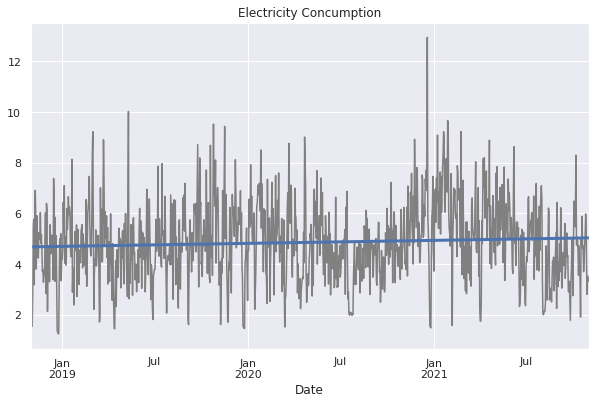

In [ ]:
plt.figure(figsize=(10, 6))
ax = data_by_day['kWh'].plot(color="0.5", title="Electricity Concumption")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

Above plot gives us the linear trend of Electricity Consumption. Now let us calculate the seasonality of it

# Seasonality

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [ ]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [ ]:
data_by_day.index = pd.to_datetime(data_by_day.index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


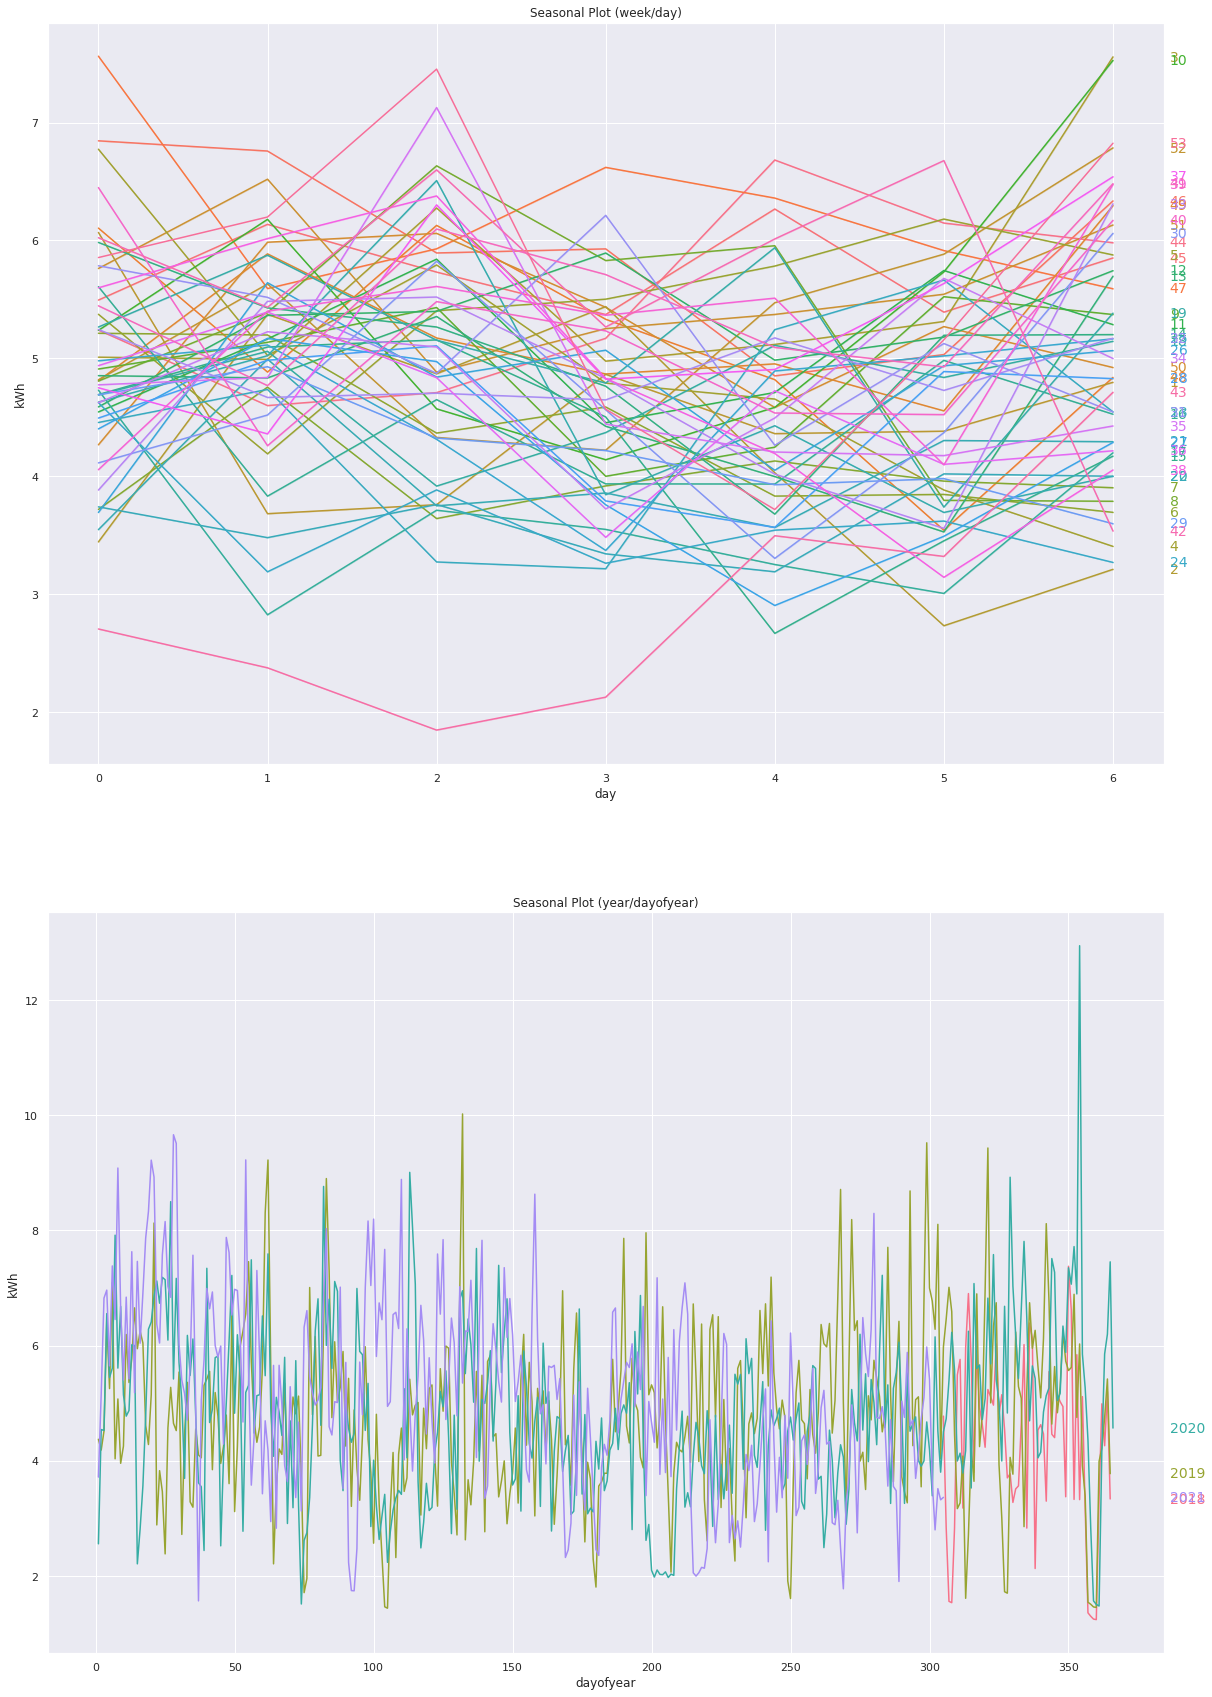

In [ ]:
X = data_by_day.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axi (freq)
X["week"] = X.index.week  # the seasonal period (period)


# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

X["month"] = X.index.month

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 30))
seasonal_plot(X, y="kWh", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="kWh", period="year", freq="dayofyear", ax=ax1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """Entry point for launching an IPython kernel.


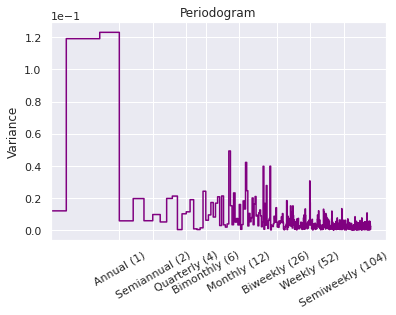

In [ ]:
plot_periodogram(data_by_day.kWh)

In [ ]:
X = data_by_day.drop('kWh', axis=1)
y = data_by_day['kWh']

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=1)  # 1 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=data_by_day.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

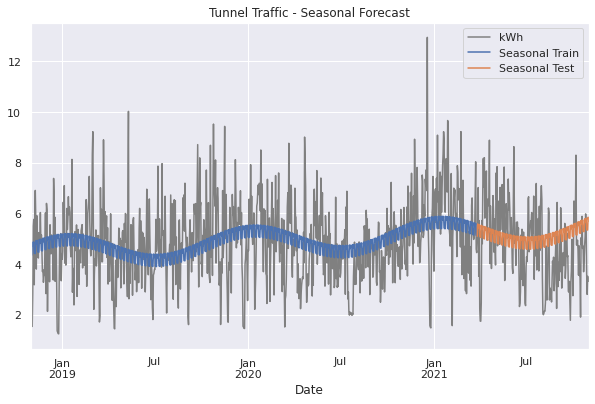

In [ ]:
model = LinearRegression(fit_intercept=False)
_ = model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_train), index=X_train.index)
y_fore = pd.Series(model.predict(X_test), index=X_test.index)

plt.figure(figsize=(10, 6))
ax = y.plot(color='0.5', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal Train")
ax = y_fore.plot(ax=ax, label="Seasonal Test")
_ = ax.legend()

# Lags

In [ ]:
data_by_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1097 entries, 2018-11-01 to 2021-11-01
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   kWh                   1097 non-null   float64
 1   pressure_at_sea       1097 non-null   float64
 2   precip_dur_past10min  1097 non-null   float64
 3   wind_dir              1097 non-null   float64
 4   temp_dew              1097 non-null   float64
 5   pressure              1097 non-null   float64
 6   visib_mean_last10min  1097 non-null   float64
 7   temp_dry              1097 non-null   float64
 8   humidity              1097 non-null   float64
 9   cloud_cover           1097 non-null   float64
 10  visibility            1097 non-null   float64
dtypes: float64(11)
memory usage: 135.1 KB


In [ ]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

from statsmodels.graphics.tsaplots import plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


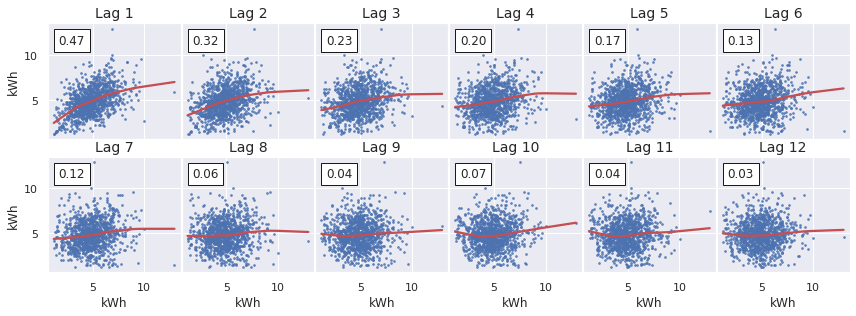

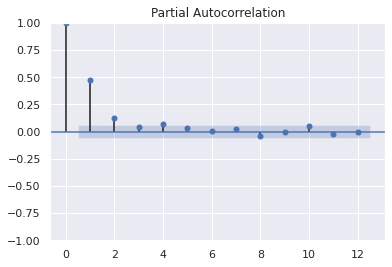

In [ ]:
_ = plot_lags(data_by_day.kWh, lags=12, nrows=2)
_ = plot_pacf(data_by_day.kWh, lags=12)

As the plot indicates we have to use 2 lags of the data

In [ ]:
lags = pd.DataFrame({
    'y_lag_1': data_by_day['kWh'].shift(1),
    'y_lag_2': data_by_day['kWh'].shift(2),    
})

lags = lags.fillna('0')
lags

,y_lag_1,y_lag_2
Date,,
2018-11-01,0,0
2018-11-02,4.775,0
2018-11-03,2.835,4.775
2018-11-04,1.559,2.835
2018-11-05,1.536,1.559
...,...,...
2021-10-28,5.418,5.976
2021-10-29,3.613,5.418
2021-10-30,2.8,3.613


In [ ]:
X = X.join(lags)

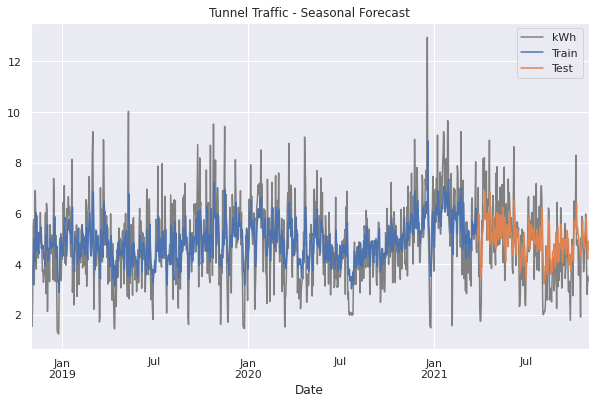

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = LinearRegression(fit_intercept=False)
_ = model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_train), index=X_train.index)
y_fore = pd.Series(model.predict(X_test), index=X_test.index)

plt.figure(figsize=(10, 6))
ax = y.plot(color='0.5', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Train")
ax = y_fore.plot(ax=ax, label="Test")
_ = ax.legend()

# Metereology Features

After analyzing the time features now let us add the additional metereology features

In [ ]:
data_by_day.head()

,kWh,pressure_at_sea,precip_dur_past10min,wind_dir,temp_dew,pressure,visib_mean_last10min,temp_dry,humidity,cloud_cover,visibility
Date,,,,,,,,,,,
2018-11-01,4.775,1013.800000,0.000000,108.416667,7.006250,1007.004167,21387.500001,8.580556,89.986111,50.694444,20273.611111
2018-11-02,2.835,1014.878472,0.013889,218.444444,7.073611,1008.075694,20074.305556,8.381944,91.659722,70.659722,18984.722222
2018-11-03,1.559,1026.250695,0.000000,208.854167,4.184028,1019.306250,26798.611111,5.768056,90.034722,2.118056,25729.166668
2018-11-04,1.536,1021.014583,0.000000,146.381944,5.393056,1014.110417,9704.166667,6.134028,95.131944,60.902778,9334.722222
2018-11-05,2.833,1014.650000,0.000000,101.263889,8.660417,1007.852778,3318.472222,8.827778,98.979167,100.000000,3296.527778


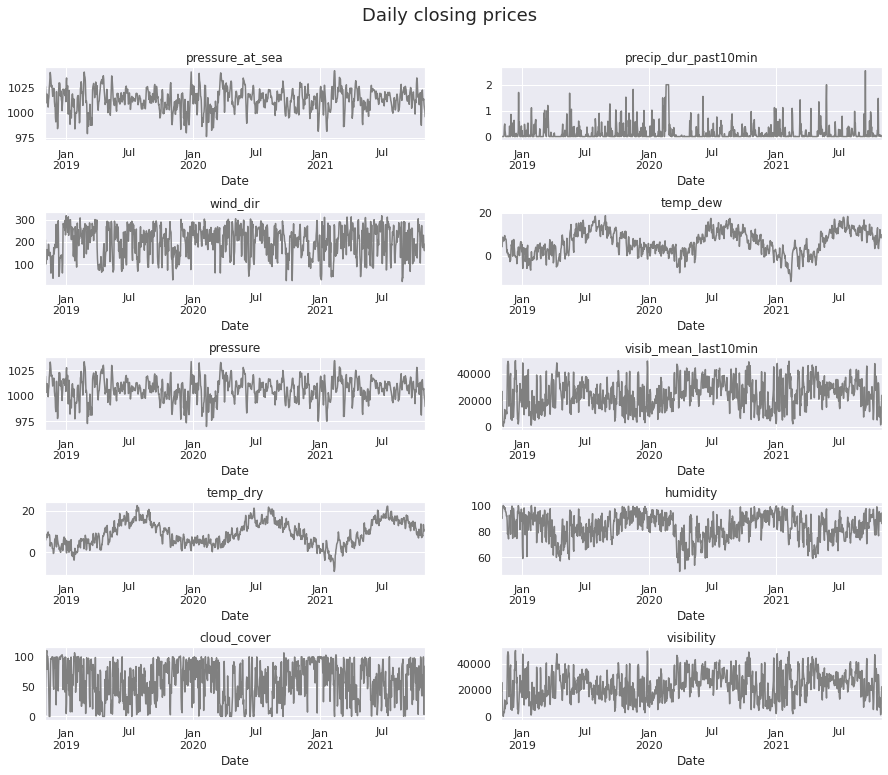

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=1)
fig.suptitle("Daily closing prices", fontsize=18, y=0.95)

for i, ax in zip(range(1, data_by_day.shape[1]), axs.ravel()):
    data_by_day[data_by_day.columns[i]].plot(color="0.5", ax=ax)
    ax.set_title(data_by_day.columns[i])

[07:21:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


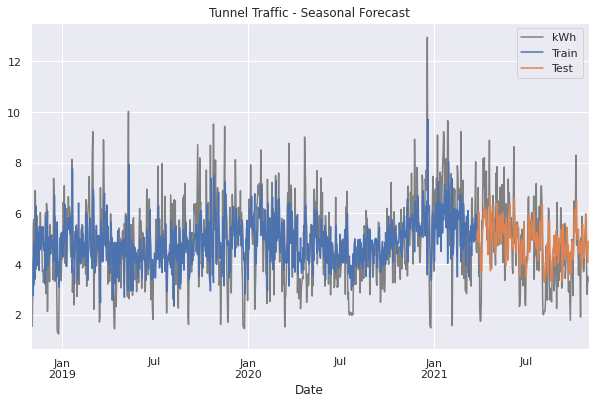

In [ ]:
X1 = data_by_day.drop('kWh', axis=1)

from xgboost import XGBRegressor

X_train1, X_test1 = train_test_split(X1, test_size=0.2, shuffle=False)

y_resid = y_pred - y_train

xgb = XGBRegressor()
xgb.fit(X_train1, y_resid)

# Add the predicted residuals onto the predicted trends
y_pred_boosted = xgb.predict(X_train1) + y_pred
y_fore_boosted = xgb.predict(X_test1) + y_fore

plt.figure(figsize=(10, 6))
ax = y.plot(color='0.5', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred_boosted.plot(ax=ax, label="Train")
ax = y_fore_boosted.plot(ax=ax, label="Test")
_ = ax.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


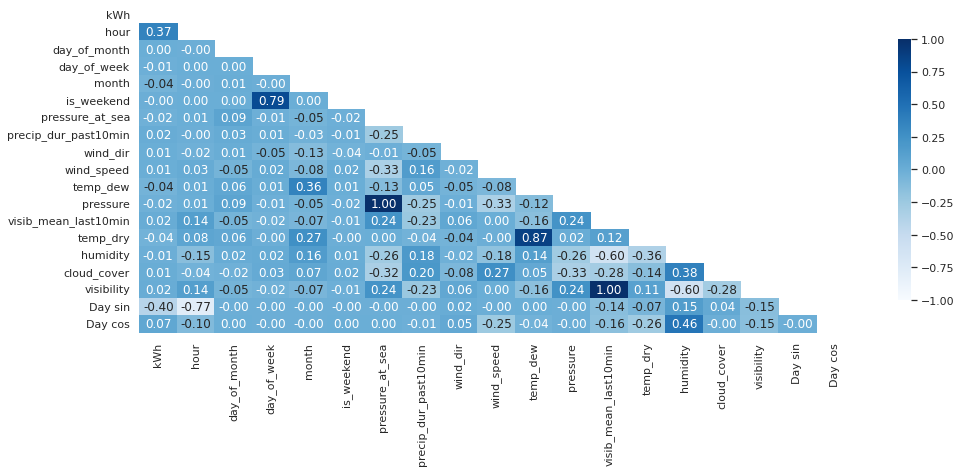

In [ ]:
# Setup environment
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
# set styles
register_matplotlib_converters()
# set seaborn style
sns.set(style='whitegrid', palette='muted', font_scale=1)
# set plotting parameters
rcParams['figure.figsize'] = 16, 6

# Load data Mac
df_input = pd.read_csv('/content/weather-energy-data-update.csv', index_col="Datetime", parse_dates=True)

# create daily, weekly, and yearly signals 
# Set datetime as index
timestamp_s = df_input.index.map(pd.Timestamp.timestamp)
day = 24*60*60
week = 24*60*60*7
year = (365.2425)*day

df_input['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_input['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

# get correlations 
df_input_corr = df_input.corr()
# create mask
mask = np.triu(np.ones_like(df_input_corr, dtype=np.bool))
# plot heatmap
sns.heatmap(df_input_corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
            vmin=-1, vmax=1, cbar_kws={"shrink": .8})

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import libraries for time series analysis
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tools.eval_measures import mse,rmse 
from sklearn.metrics import mean_absolute_percentage_error as maperror    # for ETS Plots
from pmdarima import auto_arima  

# load dataset
df_input1 = df_input['20181101':'20211031']

# dataframe for SARIMAX
df_H = df_input1[['kWh', 'hour']]
# df_H['hour'] = df_H['hour'].astype("category")

# add weekly dummy variables 
df_H_dummies = pd.get_dummies(df_H['hour'])
df_H_dummies.drop(df_H_dummies.iloc[:,2:26], inplace=True, axis=1)
df_H = pd.merge(df_H, df_H_dummies, how='left', left_index=True, right_index=True)
df_H.drop('hour', inplace=True, axis=1)

# reduce series load to circumvent scaling issues with auto_arima 
df_H_auto = df_H['20211001':'20211031']

In [ ]:
# run auto arima on hourly data ARIMA
auto_arima(df_H_auto['kWh']).summary() 
# SARIMAX(2, 0, 0) 

# run auto arima on hourly data SARIMA
auto_arima(df_H_auto['kWh'],seasonal=True,m=24).summary()
# SARIMAX(2, 0, 0)x(2, 0, 0, 24) 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  744
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 24)   Log Likelihood                 122.285
Date:                            Mon, 27 Jun 2022   AIC                           -232.570
Time:                                    07:34:43   BIC                           -204.898
Sample:                                         0   HQIC                          -221.903
                                            - 744                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0930      0.018      5.118      0.000       0.057       0.129
ar.L1          0.2494      0.028      8.968      0.000       0.195       0.304
ar.L2          0.1221      0.029      4.208      0.000       0.065       0.179
ar.S.L24       0.1232      0.036      3.439      0.001       0.053       0.193
ar.S.L48       0.1039      0.034      3.014      0.003       0.036       0.171
sigma2         0.0421      0.001     31.525      0.000       0.039       0.045
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7074.65
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             3.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# run ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
# use ADF function       
adf_test(df_H['kWh'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.365825e+01
p-value                 1.538983e-25
# lags used             4.800000e+01
# observations          2.625500e+04
critical value (1%)    -3.430599e+00
critical value (5%)    -2.861650e+00
critical value (10%)   -2.566829e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
# Train Test set split - we want to forecast 1 month into the future so out test set should be at least one month 
df = df_H
len(df)
# we will go with a train-test split such that our test set represents 168 Hours worth of data
train1 =  df[:len(df)-168]
test1 = df[len(df)-168:]
len(df) == len(train1) + len(test1) # True

# forecast start and end
# obtain predicted results
start1 = len(train1)
end1 = len(train1)+len(test1)-1

# vector of exogenous variable
exog_train = train1.iloc[:,1:] 
exog_forecast = test1.iloc[:,1:] 

In [ ]:
# Model WITHOUT Exogenous

# Fit ARIMA WITHOUT EXOGENOUS
model = SARIMAX(train1['kWh'],order=(2,0,0),enforce_invertibility=False)
results = model.fit()
results.summary()

# predict
predictions = results.predict(start=start1, end=end1).rename('ARIMA(2,0,0) Predictions')


# Fit SARIMA WITHOUT EXOGENOUS
model1 = SARIMAX(train1['kWh'],order=(2,0,0),seasonal_order=(2,0,0,24),enforce_invertibility=False)
results1 = model1.fit()
results1.summary()

# predict
predictions1 = results1.predict(start=start1, end=end1).rename('SARIMA(2,0,0)(2,0,0,24) Predictions')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


[Text(0, 0.5, 'kWh'), Text(0.5, 0, '')]

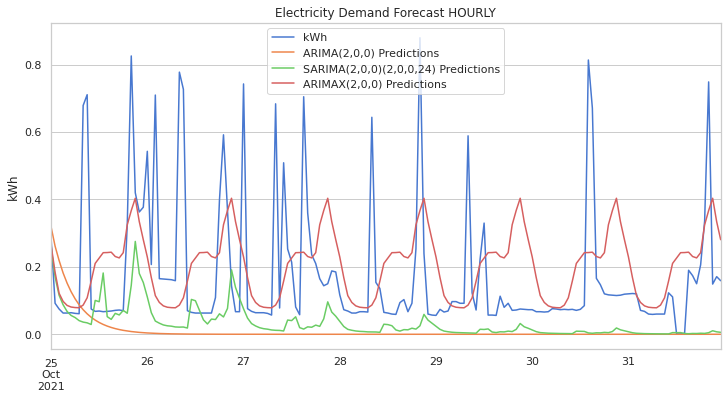

In [ ]:
# Model WITH Exogenous

# Fit ARIMAX WITH EXOGENOUS
model2 = SARIMAX(train1['kWh'],exog=exog_train,order=(2,0,0),enforce_invertibility=False)
results2 = model2.fit()
results2.summary()

# predict
predictions2 = results2.predict(start=start1, end=end1, exog=exog_forecast).rename('ARIMAX(2,0,0) Predictions')



# plot predictions
title='Electricity Demand Forecast HOURLY'
ylabel='kWh'
xlabel=''

ax = test1['kWh'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
# predictions3.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [ ]:
# # Fit SARIMA WITH EXOGENOUS
# model3 = SARIMAX(train1['kWh'],exog=exog_train,order=(2,0,0),seasonal_order=(2,0,0,24),enforce_invertibility=False)
# results3 = model3.fit()
# results3.summary()

# # predict
# predictions3 = results3.predict(start=start1, end=end1, exog=exog_forecast).rename('SARIMAX(2,0,0)(2,0,0,24) Predictions')


In [ ]:
# Evaluate model performance
error1 = mse(test1['kWh'], predictions)
error2 = rmse(test1['kWh'], predictions)
error3 = mse(test1['kWh'], predictions1)
error4 = rmse(test1['kWh'], predictions1)
error5 = mse(test1['kWh'], predictions2)
error6 = rmse(test1['kWh'], predictions2)
# error7 = mse(test1['kWh'], predictions3)
# error8 = rmse(test1['kWh'], predictions3)
# error9 = mse(test['kWh'], test['LSTM Predictions'])
# error10 = rmse(test['kWh'], test['LSTM Predictions'])


print(f'ARIMA(2,0,0) MSE Error: {error1:11.10}')
print(f'ARIMA(2,0,0) RMSE Error: {error2:11.10}')
print(f'ARIMAX(2,0,0)  MSE Error: {error5:11.10}')
print(f'ARIMAX(2,0,0)  RMSE Error: {error6:11.10}')
print(f'SARIMA(2,0,2)(2,0,0,24) MSE Error: {error3:11.10}')
print(f'SARIMA(2,0,2)(2,0,0,24) RMSE Error: {error4:11.10}')
# print(f'SARIMAX(2,0,2)(2,0,0,24) MSE Error: {error7:11.10}')
# print(f'SARIMAX(2,0,2)(2,0,0,24) RMSE Error: {error8:11.10}')
# print(f'LSTM MSE Error: {error9:11.10}')
# print(f'LSTM RMSE Error: {error10:11.10}')

ARIMA(2,0,0) MSE Error: 0.06903767671
ARIMA(2,0,0) RMSE Error: 0.2627502173
ARIMAX(2,0,0)  MSE Error: 0.04401179512
ARIMAX(2,0,0)  RMSE Error: 0.2097898833
SARIMA(2,0,2)(2,0,0,24) MSE Error: 0.05949651117
SARIMA(2,0,2)(2,0,0,24) RMSE Error: 0.2439190668


In [ ]:
# # import libraries for Deep Learning
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import LSTM


# # prepare data
# df = df_input[['kWh']]

# # Train Test set split - we want to forecast 1 week or 168 observations into the future so out test set should be at least one week 
# len(df)
# # we will go with a 168 observations test set
# train =  df[:len(df)-168]
# test = df[len(df)-168:]
# len(df) == len(train) + len(test)

# # Scale data
# scaler = MinMaxScaler()

# # Only fit to train data else we are leaking information into our test data
# scaler.fit(train)
# scaled_train = scaler.transform(train)
# scaled_test = scaler.transform(test)
# # scaled_train = train
# # scaled_test = test


# # Let's define to get 168 Days back wich represents exactly one week and then predict the next week out
# n_input = 168
# n_features = 1
# generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=10)

# # Define Simple LSTM model
# # define model
# model = Sequential()
# model.add(LSTM(16, activation='relu', input_shape=(n_input, n_features)))
# model.add(Dense(1))
# # comile model
# model.compile(optimizer='adam', loss='mse')

# # get model summary
# model.summary()

# # fit model
# model.fit_generator(generator,epochs=30, shuffle=False)

# # model performance
# model.history.history.keys()
# loss_per_epoch = model.history.history['loss']
# plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# # Evaluate on Test Data
# # first_eval_batch = scaled_train[-24:]
# # first_eval_batch
# # first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
# # model.predict(first_eval_batch)
# # scaled_test[0]

# # Loop to get predictions for all 168 observations in test set
# test_predictions = []

# first_eval_batch = scaled_train[-n_input:]
# current_batch = first_eval_batch.reshape((1, n_input, n_features))

# for i in range(len(test)):
    
#     # get prediction for 1 time stamp ahead
#     current_pred = model.predict(current_batch)[0]
    
#     # store prediciton by appending to list
#     test_predictions.append(current_pred) 
    
#     # update batch and drop first value
#     current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
# test_predictions

# # Inverse transform the previosuly transformed data to get actual data values
# true_predictions = scaler.inverse_transform(test_predictions)
# true_predictions

# # Add to dataframe
# test['LSTM Predictions'] = true_predictions

# # plot all predictions (ARIMA, SARIMA, ARIMAX, SARIMAX, LSTM)
# title='Electricity Demand Forecast HOURLY'
# ylabel='kWh'
# xlabel=''

# ax = test1['kWh'].plot(legend=True,figsize=(12,4),title=title)
# predictions.plot(legend=True)
# predictions2.plot(legend=True)
# predictions1.plot(legend=True)
# predictions3.plot(legend=True)
# test['LSTM Predictions'].plot(legend=True)
# ax.autoscale(axis='x',tight=True)
# ax.set(xlabel=xlabel, ylabel=ylabel)


# # Evaluate model performance
# error1 = mse(test1['kWh'], predictions)
# error2 = rmse(test1['kWh'], predictions)
# error3 = mse(test1['kWh'], predictions1)
# error4 = rmse(test1['kWh'], predictions1)
# error5 = mse(test1['kWh'], predictions2)
# error6 = rmse(test1['kWh'], predictions2)
# error7 = mse(test1['kWh'], predictions3)
# error8 = rmse(test1['kWh'], predictions3)
# error9 = mse(test['kWh'], test['LSTM Predictions'])
# error10 = rmse(test['kWh'], test['LSTM Predictions'])


# print(f'ARIMA(2,0,0) MSE Error: {error1:11.10}')
# print(f'ARIMA(2,0,0) RMSE Error: {error2:11.10}')
# print(f'ARIMAX(2,0,0)  MSE Error: {error5:11.10}')
# print(f'ARIMAX(2,0,0)  RMSE Error: {error6:11.10}')
# print(f'SARIMA(2,0,2)(2,0,0,24) MSE Error: {error3:11.10}')
# print(f'SARIMA(2,0,2)(2,0,0,24) RMSE Error: {error4:11.10}')
# print(f'SARIMAX(2,0,2)(2,0,0,24) MSE Error: {error7:11.10}')
# print(f'SARIMAX(2,0,2)(2,0,0,24) RMSE Error: {error8:11.10}')
# print(f'LSTM MSE Error: {error9:11.10}')
# print(f'LSTM RMSE Error: {error10:11.10}')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5)                 140       
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


 432/2600 [===>..........................] - ETA: 1:51 - loss: 0.0071

KeyboardInterrupt: ignored

In [ ]:
#ADDING NOISE

In [ ]:
def run_with_p(p):
    return np.random.uniform() < p

In [ ]:
def add_noise(df, noise_mode, noise_level = 0.2):
    noised = df.copy()

    if noise_mode == 1: # AWGN nosie
        SNR = noise_level
        SNR_times = 10 ** (SNR / 10.)

        continuous_features =  list(df)
        signal_powers = (abs(df) ** 2).mean()

        for feature in continuous_features:
            if feature != 'Target':
                signal_power = signal_powers[feature]
                noise_power = signal_power / SNR_times
                noise = np.random.normal(0,1,df.shape[0])
                noise *= np.sqrt(noise_power)
                noised[feature] += noise
    return noised

In [ ]:
#DROP

In [ ]:
def drop_values(df, dropping_mode, dropping_probability = 0.25):
    with_drops = df.copy()
    
    if dropping_mode == 1: # MCAR
        for i in range(df.shape[1]):
            if df.columns[i] != 'Target':
                for j in range(df.shape[0]):
                    if run_with_p(dropping_probability):
                        with_drops.iloc[j, i] = None
    elif dropping_mode == 2: # NMAR
        Aj = with_drops.copy()
        Aj.drop(columns=['Target'], inplace=True)
        jcols = Aj.columns
        
        for col in range(Aj.shape[1]):
            if Aj.dtypes[col] != 'object':
                med = Aj.iloc[:,col].median()
                if np.random.randint(2):
                    for row in range(Aj.shape[0]):
                        if Aj.iloc[row, col] < med:
                            if run_with_p(2*dropping_probability):
                                with_drops.loc[row, jcols[col]]=None
                else:
                    for row in range(Aj.shape[0]):
                        if Aj.iloc[row, col] > med:
                            if run_with_p(2*dropping_probability):
                                with_drops.loc[row, jcols[col]]=None
            else:
                classes=Aj.iloc[:,col].unique()
                subset_size = int(np.floor(len(classes)/2))
                subset=np.random.choice(classes, size = subset_size, replace = False, p = None)
                for row in range(Aj.shape[0]):
                    if Aj.iloc[row, col] in subset:
                        if run_with_p(2*dropping_probability):
                            with_drops.loc[row, jcols[col]]=None
                        
    return with_drops

In [ ]:
def impute_data(df, imputation_mode):    
    if imputation_mode == 0: # dropping
        filled = df.dropna()
    elif imputation_mode == 1: # filling with 0
        filled = df.fillna(0)
    elif imputation_mode == 2: # filling with mean
        filled = df.copy()

        categorical_features = list(df.columns[df.dtypes == "object"])
        continuous_features =  list(df.columns[df.dtypes != "object"])

        for feature in categorical_features:
            filled[feature].fillna(filled[feature].value_counts().index[0], inplace=True)
        for feature in continuous_features:
            filled[feature].fillna(filled[feature].mean(), inplace=True)
    elif imputation_mode == 3: # filling with median
        filled = df.copy()

        categorical_features = list(df.columns[df.dtypes == "object"])
        continuous_features =  list(df.columns[df.dtypes != "object"])

        for feature in categorical_features:
            filled[feature].fillna(filled[feature].value_counts().index[0], inplace=True)
        for feature in continuous_features:
            filled[feature].fillna(filled[feature].median(), inplace=True)
    elif imputation_mode == 4: # filling by MICE
        y = df['Target']
        X = df.drop('Target', axis = 1)

        kds = mf.ImputationKernel(
          X,
          datasets=1,
          save_all_iterations=False,
          random_state=random_state
        )

        kds.mice(5)

        X_filled = kds.complete_data(dataset=0, inplace=False)

        filled = pd.concat([X_filled,y], axis=1)
    elif imputation_mode == 5: # filling by KNN
        y = df['Target']
        X = df.drop('Target', axis = 1)

        imputer = KNNImputer(n_neighbors=5)
        X_filled = imputer.fit_transform(X)

        for col in range(X.shape[1]):
            X.iloc[:,col] = X_filled[:,col]

        filled = pd.concat([X,y], axis=1)
        
    return filled

In [ ]:
train1['kWh']

Datetime
2018-11-01 00:00:00    0.247
2018-11-01 01:00:00    0.131
2018-11-01 02:00:00    0.132
2018-11-01 03:00:00    0.076
2018-11-01 04:00:00    0.061
                       ...  
2021-10-24 19:00:00    0.189
2021-10-24 20:00:00    0.227
2021-10-24 21:00:00    0.657
2021-10-24 22:00:00    0.499
2021-10-24 23:00:00    0.366
Name: kWh, Length: 26136, dtype: float64

In [ ]:
trn_wn = add_noise(train1, 1)

In [ ]:
# Model WITHOUT Exogenous

# Fit ARIMA WITHOUT EXOGENOUS
model = SARIMAX(trn_wn['kWh'],order=(2,0,0),enforce_invertibility=False)
results = model.fit()
results.summary()

# predict
predictions = results.predict(start=start1, end=end1).rename('ARIMA(2,0,0) Predictions')


# Fit SARIMA WITHOUT EXOGENOUS
model1 = SARIMAX(trn_wn['kWh'],order=(2,0,0),seasonal_order=(2,0,0,24),enforce_invertibility=False)
results1 = model1.fit()
results1.summary()

# predict
predictions1 = results1.predict(start=start1, end=end1).rename('SARIMA(2,0,0)(2,0,0,24) Predictions')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


[Text(0, 0.5, 'kWh'), Text(0.5, 0, '')]

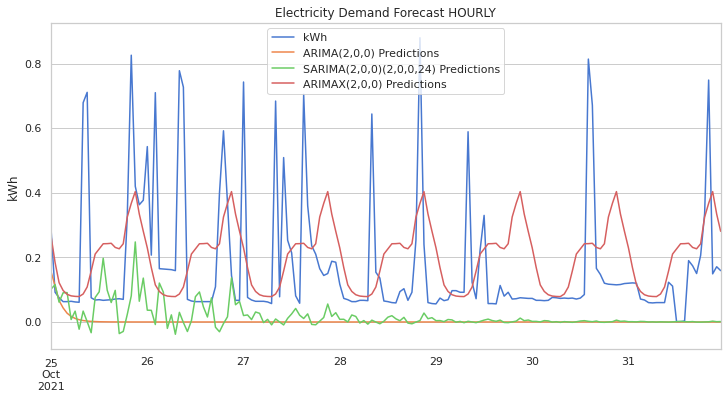

In [ ]:
# Model WITH Exogenous

# Fit ARIMAX WITH EXOGENOUS
model2 = SARIMAX(trn_wn['kWh'],exog=exog_train,order=(2,0,0),enforce_invertibility=False)
results2 = model2.fit()
results2.summary()

# predict
predictions2 = results2.predict(start=start1, end=end1, exog=exog_forecast).rename('ARIMAX(2,0,0) Predictions')



# plot predictions
title='Electricity Demand Forecast HOURLY'
ylabel='kWh'
xlabel=''

ax = test1['kWh'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
# predictions3.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [ ]:
# # Fit SARIMA WITH EXOGENOUS
# model3 = SARIMAX(train1['kWh'],exog=exog_train,order=(2,0,0),seasonal_order=(2,0,0,24),enforce_invertibility=False)
# results3 = model3.fit()
# results3.summary()

# # predict
# predictions3 = results3.predict(start=start1, end=end1, exog=exog_forecast).rename('SARIMAX(2,0,0)(2,0,0,24) Predictions')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


KeyboardInterrupt: ignored

In [ ]:
# Evaluate model performance
error1 = mse(test1['kWh'], predictions)
error2 = rmse(test1['kWh'], predictions)
error3 = mse(test1['kWh'], predictions1)
error4 = rmse(test1['kWh'], predictions1)
error5 = mse(test1['kWh'], predictions2)
error6 = rmse(test1['kWh'], predictions2)
# error7 = mse(test1['kWh'], predictions3)
# error8 = rmse(test1['kWh'], predictions3)
# error9 = mse(test['kWh'], test['LSTM Predictions'])
# error10 = rmse(test['kWh'], test['LSTM Predictions'])


print(f'ARIMA(2,0,0) MSE Error: {error1:11.10}')
print(f'ARIMA(2,0,0) RMSE Error: {error2:11.10}')
print(f'ARIMAX(2,0,0)  MSE Error: {error5:11.10}')
print(f'ARIMAX(2,0,0)  RMSE Error: {error6:11.10}')
print(f'SARIMA(2,0,2)(2,0,0,24) MSE Error: {error3:11.10}')
print(f'SARIMA(2,0,2)(2,0,0,24) RMSE Error: {error4:11.10}')
# print(f'SARIMAX(2,0,2)(2,0,0,24) MSE Error: {error7:11.10}')
# print(f'SARIMAX(2,0,2)(2,0,0,24) RMSE Error: {error8:11.10}')
# print(f'LSTM MSE Error: {error9:11.10}')
# print(f'LSTM RMSE Error: {error10:11.10}')

ARIMA(2,0,0) MSE Error: 0.07015438496
ARIMA(2,0,0) RMSE Error: 0.2648667306
ARIMAX(2,0,0)  MSE Error: 0.04401179512
ARIMAX(2,0,0)  RMSE Error: 0.2097898833
SARIMA(2,0,2)(2,0,0,24) MSE Error: 0.06568838964
SARIMA(2,0,2)(2,0,0,24) RMSE Error: 0.2562974632


In [ ]:
with_drops = drop_values(train1, 1)

In [ ]:
imputed = impute_data(with_drops, 3)

In [ ]:
# Model WITHOUT Exogenous

# Fit ARIMA WITHOUT EXOGENOUS
model = SARIMAX(imputed['kWh'],order=(2,0,0),enforce_invertibility=False)
results = model.fit()
results.summary()

# predict
predictions = results.predict(start=start1, end=end1).rename('ARIMA(2,0,0) Predictions')


# Fit SARIMA WITHOUT EXOGENOUS
model1 = SARIMAX(imputed['kWh'],order=(2,0,0),seasonal_order=(2,0,0,24),enforce_invertibility=False)
results1 = model1.fit()
results1.summary()

# predict
predictions1 = results1.predict(start=start1, end=end1).rename('SARIMA(2,0,0)(2,0,0,24) Predictions')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


[Text(0, 0.5, 'kWh'), Text(0.5, 0, '')]

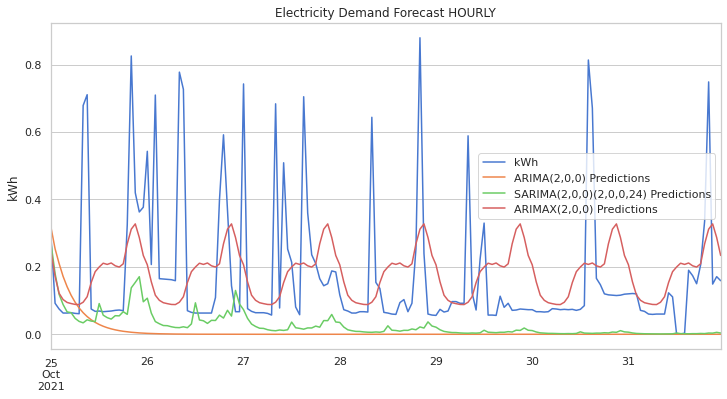

In [ ]:
# Model WITH Exogenous

# Fit ARIMAX WITH EXOGENOUS
model2 = SARIMAX(imputed['kWh'],exog=exog_train,order=(2,0,0),enforce_invertibility=False)
results2 = model2.fit()
results2.summary()

# predict
predictions2 = results2.predict(start=start1, end=end1, exog=exog_forecast).rename('ARIMAX(2,0,0) Predictions')



# plot predictions
title='Electricity Demand Forecast HOURLY'
ylabel='kWh'
xlabel=''

ax = test1['kWh'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
# predictions3.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [ ]:
# Evaluate model performance
error1 = mse(test1['kWh'], predictions)
error2 = rmse(test1['kWh'], predictions)
error3 = mse(test1['kWh'], predictions1)
error4 = rmse(test1['kWh'], predictions1)
error5 = mse(test1['kWh'], predictions2)
error6 = rmse(test1['kWh'], predictions2)
# error7 = mse(test1['kWh'], predictions3)
# error8 = rmse(test1['kWh'], predictions3)
# error9 = mse(test['kWh'], test['LSTM Predictions'])
# error10 = rmse(test['kWh'], test['LSTM Predictions'])


print(f'ARIMA(2,0,0) MSE Error: {error1:11.10}')
print(f'ARIMA(2,0,0) RMSE Error: {error2:11.10}')
print(f'ARIMAX(2,0,0)  MSE Error: {error5:11.10}')
print(f'ARIMAX(2,0,0)  RMSE Error: {error6:11.10}')
print(f'SARIMA(2,0,2)(2,0,0,24) MSE Error: {error3:11.10}')
print(f'SARIMA(2,0,2)(2,0,0,24) RMSE Error: {error4:11.10}')
# print(f'SARIMAX(2,0,2)(2,0,0,24) MSE Error: {error7:11.10}')
# print(f'SARIMAX(2,0,2)(2,0,0,24) RMSE Error: {error8:11.10}')
# print(f'LSTM MSE Error: {error9:11.10}')
# print(f'LSTM RMSE Error: {error10:11.10}')

ARIMA(2,0,0) MSE Error: 0.06920046347
ARIMA(2,0,0) RMSE Error: 0.2630598097
ARIMAX(2,0,0)  MSE Error: 0.04047380516
ARIMAX(2,0,0)  RMSE Error: 0.2011810258
SARIMA(2,0,2)(2,0,0,24) MSE Error: 0.06068002744
SARIMA(2,0,2)(2,0,0,24) RMSE Error: 0.2463331635
